# Distributed optimization algorithms
The goal of this notebook is to work on distributed optimization algorithms, which are the foundation for large scale analytics and machine learning. Specifically, we will focus on the details of stochastic gradient descent (SGD). To do so, we will work on a simple regression problem, where we will apply SGD to minimize a loss function, as defined for the problem at hand. The emphasis of this laboratory is **not** on the machine learning part: even if you've never worked on regression problems, this shouldn't prevent you from being successful in developing the Notebook.

Next, an outline of the steps we will follow in this Notebook:

* Breif introduction to linear regression
* Implementation of serial algorithms: from Gradient Descent, to Stochastic Gradient Descent
* Implementation of distributed algorithms with Apache Spark


### Initialization code

In [48]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats 

from sklearn.datasets.samples_generator import make_regression

## A simple example: linear regression
Let’s see briefly how to use gradient descent in a simple least squares regression setting. Asssume we have an output variable $y$ which we think depends linearly on the input vector $x$. That is, we have:

$$x = \begin{bmatrix}x_1 \\ x_2 \\ \cdots \\ x_m\end{bmatrix}, y = \begin{bmatrix}y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix}$$

We approximate $y_i$ by:

$$ f_{\theta}(x_i) = \theta_1 + \theta_2 x_i$$

Define the loss function for the simple linear least squares regression as follows:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

Now, let's use scikit learn to create a regression problem. A few notes are in order:

* The call to ```make_regression``` essentially generates samples for a regression problem
* The call to ```stats.linegress``` calculates a linear least-squares regression for two sets of measurements

This means we have a sort of "basline" to experiment with our SGD implementation.

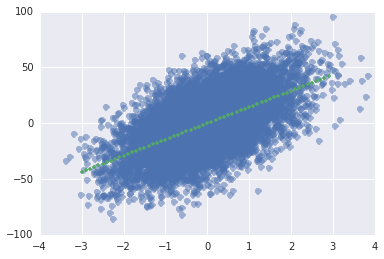

In [49]:
x, y = make_regression(n_samples = 10000, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
x = x.flatten()
slope, intercept,_,_,_ = stats.linregress(x,y)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

## Batch gradient descent
Before delving into SGD, let's take a simpler approach. Assume that we have a vector of paramters $\theta$ and a loss function $J(\theta)$, which we want to minimize. The loss function we defined above has the form:

$$ J(\theta) = \sum_{i=1}^{m} J_i(\theta)$$

where $J_i$ is associated with the i-th observation in our data set, such as the one we generated above. The batch gradient descent algorithm, starts with some initial feasible parameter $\theta$ (which we can either fix or assign randomly) and then repeatedly performs the update:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J(\theta^{(t)}) = \theta^{(t)} - \eta \sum_{i=1}^{m} \nabla_{\theta} J_i(\theta^{(t)}) $$

where $t$ is an iteration index, and $\eta$ is a constant controlling step-size and is called the learning rate. Note that in order to make a **single update**, we need to calculate the gradient **using the entire dataset**. This can be very inefficient for large datasets, and it is the goal of this Notebook to insist on this aspect.

In code, the main loop for batch gradient descent looks like this:

```python
for i in range(n_epochs):
  params_grad = evaluate_gradient(loss_function, data, params)
  params = params - learning_rate * params_grad
```

For a given number of iterations (also called epochs) $n_{e}$ , we first evaluate the gradient vector of the loss function using **ALL** examples in the data set, and then we update the parameters with a given learning rate. Batch gradient descent is guaranteed to converge to the global minimum for convex loss surfaces and to a local minimum for non-convex surfaces.

<div class="alert alert-warning">
<b>NOTE:</b> Who computes the gradient?
<br>
<br>
Given a loss function $J(\theta)$, the gradient with respect to paramters $\theta$ must be derived manually. In other words, given the expression of $J(\theta)$, pencil and paper are required to derive the analytical form of its gradient. Then this expression can be plugged into our code.

Recently, machine learning libraries have adopted the techniques of **automatic differentiation**, which eliminate this tedious and error prone step. Given a loss function $J(\theta)$, such libraries automatically compute the gradient.
</div>


For the linear regression case, let's derive the update step for gradient descent. Recall that we have defined:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

$$f_\theta(x_i) = \theta_1 + \theta_2 x_i$$

So we have that:

$$ \nabla_\theta J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (\theta_1 + \theta_2 x_i - y_i)^2 $$

If we explicit the partial derivatives of the gradient, we have:

$$\frac{\partial J(\theta)}{\partial \theta_1} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i)$$
$$\frac{\partial J(\theta)}{\partial \theta_2} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i) x_i$$

So now we can explicit the update rules for the two model parameters:

$$ \theta_1^{(t+1)} = \theta_1^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i)$$

$$ \theta_2^{(t+1)} = \theta_2^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i) x_i$$


### Using matrix notation
Now, before writing some code, let's see how can we simplify the above expressions using matrices. Note that this is not only useful for working on a more compact notation, but it helps reason about efficient computations using libraries such as numpy, which we will use extensively.

We firstly expressed our prediction as: $f_\theta (x_i) = \theta_1 + \theta_2 x_i$. Let's introduce a surrogate dimension for our input set $x$, such that:

$$x = 
\begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix}
$$

where we define, with a small abuse of notation, $x_i = \begin{bmatrix} 1 & x_{i}\end{bmatrix}$. Also, let's define vector $\theta = \begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix}$. 

Then, we can rewrite $f_\theta(x_i) = x_i \theta = \begin{bmatrix} 1 & x_{i}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} = \theta_1 + \theta_2 x_i$.

Let's use this notation to rewrite our gradients in matrix form.


$\nabla_\theta J(\theta) =  \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{m} (x_i \theta - y_i) x_i^T =$


$= x^T (x \theta - y) =$


$= \begin{bmatrix} 1 & 1 & \cdots & 1 \\ x_1 & x_2 & \cdots & x_m \end{bmatrix} 
\Bigg( \begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} - 
\begin{bmatrix} y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix} \Bigg)$

### Numpy arrays
With the work we did above, we can now cast everything into numpy arrays, which are efficient, and for which an efficient implementation of vector and matrix operations exists. Specifically, above we used the traditional matrix notation, where we manipulate column vectors. Hence, we express matrix operations (namely matrix products) using the traditional "row-by-column" approach.

In numpy, we avoid this formalism by using dot product operations. So, given two column vectors:
$$a= \begin{bmatrix} a_1 \\ a_2 \\ \cdots \\ a_{m}\end{bmatrix} b= \begin{bmatrix} b_1 \\ b_2 \\ \cdots \\ b_{m}\end{bmatrix}$$
we have that $a b^T = a \cdot b = a_1 b_1 + a_2 b_2 + \cdots + a_m b_m$, where $\cdot$ is the symbol we use for dot product.

<div class="alert alert-block alert-info">
<strong>Question 1.</strong> Implement your own version of Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>

The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position</li>
</ul>
</div>

Result obtained after 38 iterations:
	- Loss:	 201.552292681
with final parameters:
	- Theta1:	 -0.104558896253
	- Theta2:	 14.246629601
Result obtained with scikit-learn:
	- Theta1:	 -0.106823564161
	- Theta2:	 14.5151694796


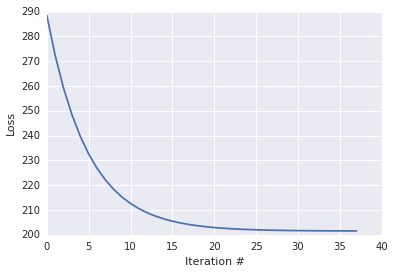

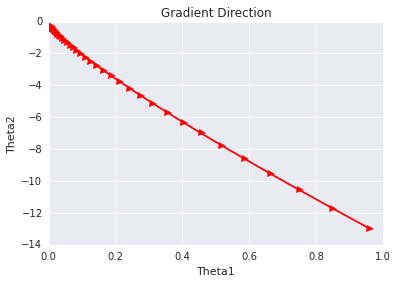

In [50]:
def gradient_descent(x, y, theta, learning_rate, n_epochs, m_impr):
    x1 = np.array([np.ones(x.size), x])
    loss_history = []
    grad_history = []
    theta_history = []
    
    best_loss_index = 0
    
    for i in range(0, n_epochs):
        # Compute parameters
        xt = np.dot(np.transpose(x1), theta)
        grad = np.dot(x1, xt - y) / x.size
        loss = np.dot((xt - y), np.transpose(xt - y)) / (2 * x.size)
        theta = theta - (learning_rate * grad)
        
        # Update parameters
        loss_history.append(loss)
        grad_history.append(grad)        
        theta_history.append(theta)
        
        # Check if we are making meaningfull improvements
        if loss_history[best_loss_index] > loss:
            if abs(loss - loss_history[best_loss_index]) < m_impr:
                break
            best_loss_index = i
                
    return np.array(theta_history), np.array(loss_history), np.array(grad_history), i+1

# Execute gradient descent function
n_epochs = 100
theta, loss_history, grad_history, n_iterations = gradient_descent(x, y, np.array([0.7, 1.2]), 0.1, n_epochs, 0.01)

# Output obtained results
print("Result obtained after", n_iterations, "iterations:")
print("\t- Loss:\t", loss_history[-1])
print("with final parameters:")
print("\t- Theta1:\t", theta[-1,0])
print("\t- Theta2:\t", theta[-1,1])

# Output scikit-learn results
print("Result obtained with scikit-learn:")
print("\t- Theta1:\t", intercept)
print("\t- Theta2:\t", slope)

# Plot loss/iteration#
plt.xlabel('Iteration #')
plt.ylabel('Loss')
plt.plot(range(0, n_iterations), loss_history)
plt.show()

# Plot gradient direction
plt.title('Gradient Direction')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.plot(grad_history[:,0], grad_history[:,1], 'r->')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 2.</strong> Plot the regression line, along with the training data, given the coefficients $\theta$ that you have obtained with Gradient Descent.
</div>

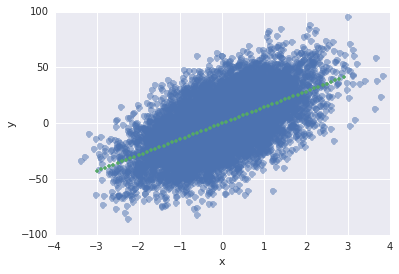

In [51]:
fx = theta[-1, 0] + theta[-1, 1]*x

slope, intercept,_,_,_ = stats.linregress(x,fx)
best_fit = np.vectorize(lambda x: x * slope + intercept)

ax = plt.axes()
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

<div class="alert alert-block alert-info">
<strong>Question 3.</strong> Plot a 3D surface representing: on the x,y axes the parameter values, on the z axis the loss value. Additionally, plot the trajectory of the loss function on the 3D surface, using the history you collected in the gradient_descent function you designed.

Finally, plot a contour projection of the 3D surface, along with the corresponding projection of the trajectory followed by your Gradient Descent algorithm.
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


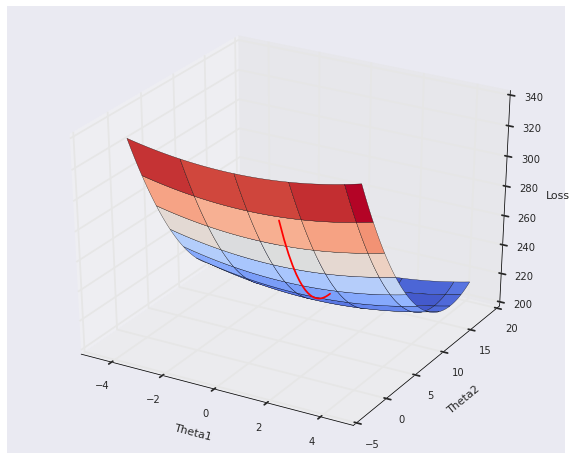

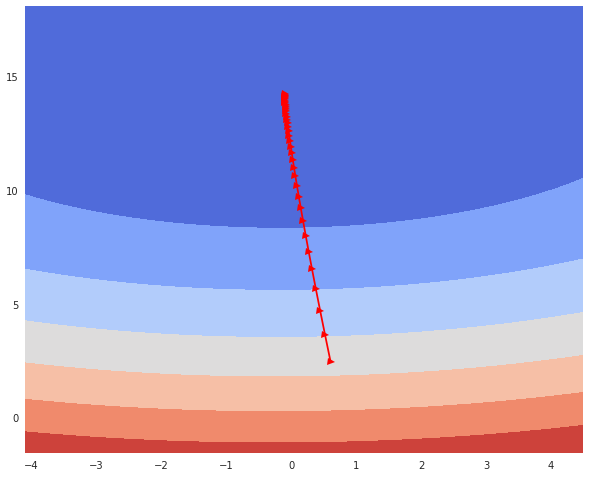

In [52]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
fig.set_size_inches(10, 8)

ax = fig.gca(projection='3d')
ax.set_xlabel('Theta1')
ax.set_ylabel('Theta2')
ax.set_zlabel('Loss')

# Plot surface
delta = 4
T1 = np.arange(np.amin(theta[:,0])-delta, np.amax(theta[:,0])+delta, 0.2)
T2 = np.arange(np.amin(theta[:,1])-delta, np.amax(theta[:,1])+delta, 0.2)
Z = np.zeros((len(T2), len(T1)))
T1, T2 = np.meshgrid(T1,T2)
for i in range(0, T1.shape[0]):
    for j in range(0, T1.shape[1]):
        loss = 0
        for k in range(0, len(x)):
            loss += (T1[i][j] + T2[i][j]*x[k] - y[k])**2
        loss /= (2*len(x))
        Z[i,j] = loss

ax.plot_surface(T1, T2, Z, cmap=cm.coolwarm)
        
# Plot trajectory
plt.plot(theta[:,0], theta[:,1], loss_history, 'r-')
plt.show()

# Plot contour projection
fig = plt.figure()
fig.set_size_inches(10, 8)

plt.contourf(T1, T2, Z, cmap=cm.coolwarm)
plt.plot(theta[:,0], theta[:,1], 'r->')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 4.</strong> Plot the path the gradient takes from its initial to its final position.

This is a two dimensional plot (because our parameter vector has size 2), with a point for each gradient value, and a line connecting the points.
</div>

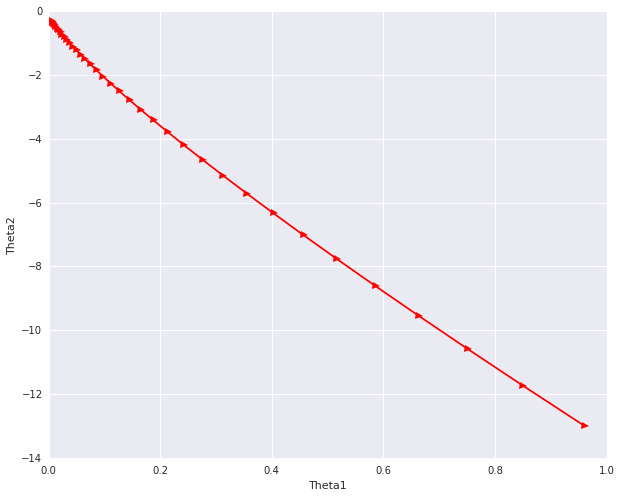

In [53]:
fig = plt.figure()
fig.set_size_inches(10, 8)

ax = plt.gca()
ax.set_xlabel('Theta1')
ax.set_ylabel('Theta2')

plt.plot(grad_history[:,0], grad_history[:,1], 'r->')
plt.show()

## Stochastic Gradient Descent

The gradient descent algorithm makes intuitive sense as it always proceeds in the direction of steepest descent (the gradient of $J$) and guarantees that we find a local minimum (global under certain assumptions on $J$). When we have very large data sets, however, computing $\nabla_\theta J(\theta)$ can be computationally challenging: as noted above, we must process every data point before making a single step (hence the name "batch"). 

An alternative approach to alleviate such computational costs is the Stochastic Gradient Descent method: essentially, the idea is to update the parameters $\theta$ sequentially (one data point at the time), with every observation $x_i, y_i$. Following the same notation we used for Gradient Descent, the following expression defines how to update parameters, while processing one data point at the time:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J_i(\theta^{(t)}) $$


The stochastic gradient approach allows us to start making progress on the minimization problem one step at the time. It is computationally cheaper, but it results in a larger variance of the loss function in comparison with batch gradient descent.

Generally, the stochastic gradient descent method will get close to the optimal $\theta$ much faster than the batch method, but will never fully converge to the local (or global) minimum. Thus the stochastic gradient descent method is useful when we are satisfied with an **approximation** for the solution to our optimization problem. 

A full recipe for stochastic gradient descent follows:

```python 
for i in range(n_epochs):
  np.random.shuffle(data)
  for example in data:
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
```

The reshuffling of the data is done to avoid a bias in the optimization algorithm by providing the data examples in a particular order.

<div class="alert alert-block alert-info">
<strong>Question 5.</strong> Implement your own version of Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>

    
The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

Result obtained after 100 iterations:
	- Loss:	 201.799073973
with final parameters:
	- Theta1:	 0.0351943625989
	- Theta2:	 14.7389099585
Result obtained with scikit-learn:
	- Theta1:	 -0.104558896253
	- Theta2:	 14.246629601


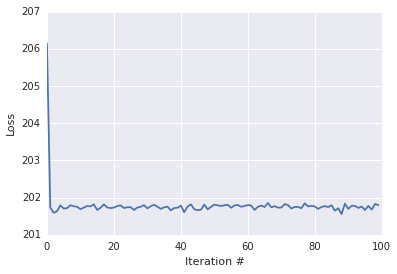

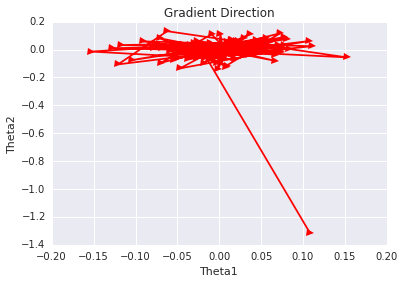

In [54]:
def stochastic_gradient_descent(x_set, y_set, theta, learning_rate, n_epochs, m_impr):
    loss_history = []
    grad_history = []
    theta_history = []
    
    th1 = theta[0]
    th2 = theta[1]
    
    best_loss_index = 0
    
    for i in range(0, n_epochs):
        # Shuffle x and y sets by keeping the index matching
        lst = list(zip(x_set, y_set))
        np.random.shuffle(lst)
        
        # Calculate the contribute to gradient for each sample value
        loss = 0
        g1,g2 = 0,0
        count = 0
        for x, y in lst:
            loss += ((th1 + th2*x - y)**2)*0.5
            
            grad1 = th1 + (x * th2) - y
            grad2 = grad1 * x            
            g1 += grad1
            g2 += grad2
            
            th1 = th1 - learning_rate * grad1 
            th2 = th2 - learning_rate * grad2 

            count += 1
        
        # Compute the loss value
        loss /= x_set.size
        
        loss_history.append(loss)
        grad_history.append([g1/count, g2/count])
        theta_history.append([th1, th2])
        
        if loss_history[best_loss_index] > loss:
            if abs(loss - loss_history[best_loss_index]) < m_impr:
                break
            best_loss_index = i
            
    return np.array(theta_history), np.array(loss_history), np.array(grad_history), i+1

n_epochs = 100

theta, loss_history, grad_history, n_iterations = stochastic_gradient_descent(x, y, np.array([0.7, 1.2]), 0.001, n_epochs, 0.01)

# Output obtained results
print("Result obtained after", n_iterations, "iterations:")
print("\t- Loss:\t", loss_history[-1])
print("with final parameters:")
print("\t- Theta1:\t", theta[-1,0])
print("\t- Theta2:\t", theta[-1,1])

# Output scikit-learn results
print("Result obtained with scikit-learn:")
print("\t- Theta1:\t", intercept)
print("\t- Theta2:\t", slope)

# Plot loss/iteration#
plt.xlabel('Iteration #')
plt.ylabel('Loss')
plt.plot(range(0, n_iterations), loss_history)
plt.show()

# Plot gradient direction
plt.title('Gradient Direction')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.plot(grad_history[:,0], grad_history[:,1], 'r->')
plt.show()

## Mini-batch Stochastic Gradient Descent

Mini-batch gradient descent is a trade-off between stochastic gradient descent and batch gradient descent.  In mini-batch gradient descent, the cost function (and therefore gradient) is averaged over a small number of samples, which is what we call the mini-batch, and that we denote by $mb$.  This is opposed to the SGD batch size of 1 sample, and the BGD size of all the training samples. 

Let's use the notation we introduced above to rewrite the gradients in matrix form for the mini-batch variant:

$\nabla_\theta J(\theta) =  \frac{1}{2 mb} \sum_{i=1}^{mb} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{mb} (x_i \theta - y_i) x_i^T =$


$= x_{mb}^T (x_{mb} \theta - y_{mb})$


What’s the benefit of doing it this way?  First, it smooths out some of the noise in SGD, but not all of it, thereby still allowing the “kick” out of local minimums of the cost function.  Second, the mini-batch size is still small, thereby keeping the performance benefits of SGD.





<div class="alert alert-block alert-info"> 
<strong>Question 6.</strong> Implement your own version of Mini-batch Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to extract mini-batches from the training data.
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>


The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

Result obtained after 100 iterations:
	- Loss:	 201.57353036
with final parameters:
	- Theta1:	 -0.0336700733275
	- Theta2:	 14.6137837802
Result obtained with scikit-learn:
	- Theta1:	 -0.104558896253
	- Theta2:	 14.246629601


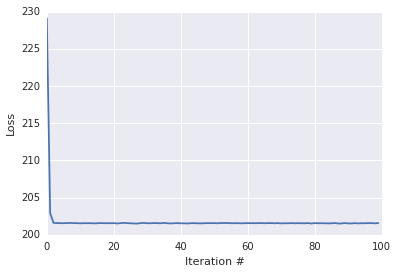

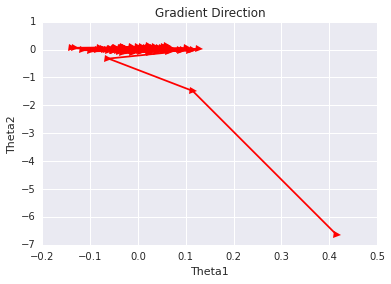

In [55]:
import math

def mini_batches(data_in, data_out, n_batches):
    assert data_in.size == data_out.size
    assert n_batches > 1
    partitions = []
    for i in range(1, n_batches):
        partitions.append(int(data_in.size * i / n_batches))
    for x, y in zip(np.split(data_in, partitions), np.split(data_out, partitions)):
        yield (x, y)

def mb_gradient_descent(x_set, y_set, theta, learning_rate, n_epochs, m_impr, n_batches = None):
    loss_history = []
    grad_history = []
    theta_history = []

    best_loss_index = 0
    
    th1 = theta[0]
    th2 = theta[1]
    
    lst = list(zip(x_set, y_set))
    
    # Compute the number of batches in case it was not given by the user
    if n_batches is None:
        # Assume we want 32 to be the size of each batch
        n_batches = math.ceil(x_set.size / 32)
    
    for i in range(0, n_epochs):
        # Shuffle x and y sets by keeping the index matching
        np.random.shuffle(lst)
        x_set,y_set = zip(*lst)
        x_set = np.array(x_set)
        y_set = np.array(y_set)
        
        # Create the batches generator
        mb = mini_batches(x_set, y_set, n_batches)
        
        loss = 0
        grad = []
        g1,g2 = 0,0
        for xb, yb in mb:
            # Compute parameters
            x1 = np.array([np.ones(xb.size), xb])
            xt = np.dot(np.transpose(x1), theta)

            grad.append((np.dot(x1, xt - yb) / xb.size))
            loss += np.dot((xt - yb), np.transpose(xt - yb)) / (2 * xb.size)
            theta = theta - (np.multiply(learning_rate, grad[-1]))
        
        # Compute the average of the parameter values
        loss_history.append(loss / n_batches)
        
        grad = np.array(grad)
        g1 = np.array(grad[:,0])
        g2 = np.array(grad[:,1])
        grad_history.append([np.mean(g1), np.mean(g2)])

        theta_history.append([theta[0], theta[1]])
        
        # Verify that we are really improving
        if loss_history[best_loss_index] > loss_history[-1]:
            if abs(loss_history[-1] - loss_history[best_loss_index]) < m_impr:
                break
            best_loss_index = i
        
    return np.array(theta_history), np.array(loss_history), np.array(grad_history), i+1

n_epochs = 100

theta, loss_history, grad_history, n_iterations = mb_gradient_descent(x, y, np.array([0.7, 1.2]), 0.005, n_epochs, 0.001)

# Output obtained results
print("Result obtained after", n_iterations, "iterations:")
print("\t- Loss:\t", loss_history[-1])
print("with final parameters:")
print("\t- Theta1:\t", theta[-1,0])
print("\t- Theta2:\t", theta[-1,1])

# Output scikit-learn results
print("Result obtained with scikit-learn:")
print("\t- Theta1:\t", intercept)
print("\t- Theta2:\t", slope)

# Plot loss/iteration#
plt.xlabel('Iteration #')
plt.ylabel('Loss')
plt.plot(range(0, n_iterations), loss_history)
plt.show()

# Plot gradient direction
plt.title('Gradient Direction')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.plot(grad_history[:,0], grad_history[:,1], 'r->')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 7.</strong> Compare the loss rate of the three approachs, Gradient Descent, Stochastic Gradient Descent, Mini-batch Stochastic Gradient Descent, by plotting in the same figure, the loss rate as a function of iterations. 


Comment the behavior of the three algorithms.
</div>

Number of iterations performed by the three algorithms:
	- Gradient Descent:	 38
	- SGD:			 100
	- Mini-batch SGD:	 100


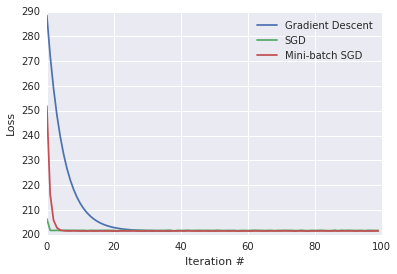

In [56]:
n_epochs = 100

_, loss_history_batch, _, n_iterations_batch = gradient_descent(x, y, np.array([0.7, 1.2]), 0.1, n_epochs, 0.01)
_, loss_history_stochastic, _, n_iterations_stochastic = stochastic_gradient_descent(x, y, np.array([0.7, 1.2]), 0.001, n_epochs, 0.001)
_, loss_history_minibatch, _, n_iterations_minibatch = mb_gradient_descent(x, y, np.array([0.7, 1.2]), 0.002, n_epochs, 0.001)

print('Number of iterations performed by the three algorithms:')
print('\t- Gradient Descent:\t', n_iterations_batch)
print('\t- SGD:\t\t\t', n_iterations_stochastic)
print('\t- Mini-batch SGD:\t', n_iterations_minibatch)

plt.xlabel("Iteration #")
plt.ylabel("Loss")
plt.plot(range(0, n_iterations_batch), loss_history_batch, label="Gradient Descent")
plt.plot(range(0, n_iterations_stochastic), loss_history_stochastic, label="SGD")
plt.plot(range(0, n_iterations_minibatch), loss_history_minibatch, label="Mini-batch SGD")
plt.legend()

The above plot shows that the algorithm that is faster in reaching a good region in the solution space is the Stochastic Gradient Descent. Anyway, given its stochastic nature, it does not stop before having performed all the given iterations. This happens because, after some initial iterations, the stochastic algorithm tends to oscillate around the optimal value without reaching it. Of course, if we accept less precise solutions, we could increase the marginal improvement value so that we can make the SGD algorithm to stop before the maximum number of iterations.

On the other side, the batch implementation of the Gradient Descent is the algorithm which requires the lowest number of iterations, despite the fact that it has a slower descent rate toward the optimal value. In fact, the Gradient Descent is deterministic and, once it reaches a "good solution", it stops if it can not improve anymore.

As expected, the Mini-batch Stochastic Gradient Descent is a sort of compromise between the other two algorithms. In fact it descents faster than Gradient Descent but slower than SGD. Moreover, given its stochastic nature, it does not stop before the given number of iterations. The same reasoning on marginal improvement made for the SGD case can be applied here.

In some cases, the two stochastic algorithms (SGD and Mini-batch) may stop before completing all the given number of iterations. This happens because, since we are always shuffling the data at each iteration, there is a probability of not improving more than the given marginal improvement value at a certain iteration.

However, the stochastic nature of SGD and Mini-batch algorithms can be better seen in the plots of the direction that the gradients assume over the different iterations, shown in the previous answers.

When plotting the above figure, the learning rate and marginal improvement parameters were slightly changed with respect to the previous answers. This choice was made because we better wanted to display the described differences between the three algorithms. Anyway, by setting the parameters to those given to the algorithms in the previous answers the result would not change.

An additional note has to be made about starting points for each algorithm. The first point of each of the three plots is already the result of the first iteration, and not any other point in the search space. This is the reason why they are all different.

All of those results match with what we were expecting from the theory.

## Distributed Mini-Batch Stochastic Gradient Descent
We're now ready to study the problem of distributed, mini-batch stochastic gradient descent. Clearly, so far we've worked with very small datasets: as a consequence it is hard to appreciate the computational bottleneck of serial implementations. But before we delve into an experimental setting, and try to spice things up with larger datasets, let's focus on the problem per se.

The problem statement is as follows: we need to design a distributed version of the algorithm we examined above, that is the Mini-Batch Stochastic Gradient Descent. In the interest of time, and also because in this laboratory we want to work with Apache Spark, we will look at **synchronous** distributed algorithms. Don'y worry, things will be much more clear in the next section!

As a complement to this introduction, here's a list of references that are useful for this Notebook, and more generally that constitute the base for those of you interested in distributed optimization algorithms, an important element of large-scale machine learning.

The first reference is a research paper that was published in 2010, in a very important conference called NIPS. I suggest to have a look at section 1 only, unless you want to pursue a PhD, in which case I strongly suggest to contact me, I'm always looking for bright students to work with!

The following references are a collection of pointers to real code, which essentially implement the ideas presented in the research paper we mentioned. Beware, this is Scala code, whereas we use Python. Nevertheless, you'll find a lot of inspiring hints for your own code. Again, I suggest to start simple, and avoid the regularization part. On another note, it is interesting to look at code that is meant to be integrated as a contribution to a popular open source software, such as Apache Spark, and in particular MLLib. This is in stark contrast to the "coding style" we adopt in this Notebook, which is to be considered experimental, and far from being compliant with any principled approach to software engineering.


#### References
* Parallelized Stochastic Gradient Descent: http://martin.zinkevich.org/publications/nips2010.pdf
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/ParallelizedSGD.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/SGDUpdater.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/test/scala/org/apache/spark/mllib/optimization/ParallelizedSGDSuite.scala

### Some useful hints to design your distibuted algorithm

In this Notebook we will use Apache Spark, which is simply a fantastic tool! As we've learned in class (and this is actually true for Hadoop MapReduce as well as for any other distributed computing framework embracing the Bulk Synchrnous Parallel (BSP) programming model), Apache Spark features a synchronization barrier that really helps in dealing with distributed computations. To simplify the discussion (a much more profound treatment of the subject can be found in this nice book http://www.parallel-algorithms-book.com/), in Apache Spark workers operate synchronously, in that the result of their computation, when aggregated or distributed, is processed only when **all** workers are done. So on the one hand, this simplifies the programming model, while on the other hand, this might introduce "stragglers", that is slow workers that penalize the performance of your distributed algorithm.

So what are the basic steps you should follow to design and implement your distributed algorithm?

#### Algorithm pseudo-code
In what follows, we outline the algorithm pseudo-code, to help you think about your algorithm implementation.

```python
for i in range(iterations)
  
  # Randomly partition the input, giving T examples to each machine.
  mini_batches = sample(input_data)

  # Initialize random paramters
  params = initialize
  
  # This part executes in parallel, on each of the k worker machines
  # This is essentially the same code as for the serial implementation
  # Indeed, we're working on an embarassingly parallel formulation
  for data in mini_batch: 
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
    
  # Here we aggregate from all machines, and compute the update for iteration i
  # The update is simply the average of all updates coming from each of the k worker machines
  Aggregate from all computers params = average(params_k)
```

#### Input data and parameters
As for the input data, we want to use the same procedure we used from the beginning of the Notebook: we use scikit learn to generate our $x$ and $y$.
Then, you have to find ways to **partition** this data across the machines you have in your cluster. The method ```sc.parallelize``` comes handy here.

Once you have a parallel collection, that takes the form of an ```RDD```, you'll have to ```sample``` from it, to create random mini batches, each of which will be used **independently** by each worker machine to process its own data. Be careful that here we want to **keep the data partitioning** of our original data. You should be wise enough to lookup for the PySpark API to get the details of the methods we suggested here: ```sample``` and ```mapPartitions```.

Last but not least, we have to take care about the parameters! The initial parameter values, as well as any updates to them, must be shipped to all worker machines. There are various ways to do this, exploiting the great flexibility of Apache Spark. This data could be serialized and shipped along with the code each task should execute. However, a much more efficient method to do this is to exploit what we have learned in class, namely ```broadcast variables```. You might argue that for our simple Notebook, since the parameter vector is of size 2, this is not a big deal. However, for different scenarios, like big models, having an efficient primitive to ship a lot of data to workers is a big plus: remember that broadcast variables are sent to workers using a protocol very similar to BitTorrent, a famous peer-to-peer content distribution system.

#### Driver vs. workers

Now, to clarify even further what we expect from our Apache Spark program, here's some additional information about the roles of each component invovled in the execution of the pseudo-code outlined above.


Essentially, the ```driver``` machine (the one where the ```SparkContext``` is created), is the one responsible for executing the "serial" part of the algorithm: prepare and dispatch data, and wait for the contributions coming from all machines.


Instead, the ```worker``` machines receive their task to execute, proceed independently (some faster than others), and send their updates to the driver. The driver will **wait for all updates from workers** before proceeding with the final aggregation.

#### Additional hints

As you might have heard in class, Apache Spark has a lot of surprises. On of such cool methods allow you to define the way data is aggregated. Indeed, you surely realized that (in the old Hadoop MapReduce jargon) we're talking about a "map only job": workers "map" on their minibatch, computing partial gradient updates, then send everything (more or less at the same time) to the driver machine. At the scale of this Notebook, this is rather harmless. Instead, at larger scale, this could create "congestion" in the driver: a nice solution to this would be to have the possibility to aggregate data along a tree-structure, which would involve worker machines as well as the driver.


One final note. In case you wonder how to produce an ```iterable``` in python with a singleton in it, just ```return (variable, )```.

<div class="alert alert-block alert-info">
<strong>Question 8.</strong> Implement your own version of Mini-Batch, Stochastic Gradient Descent, as a **distributed** algorithm.

    
The output of your cell should contain the following information:
<ul>
<li> The values of the paramters obtained through Gradient Descent optimization </li>
<li> The values of the paramters obtained with the above cell, using scikitlearn </li>
<li> A plot of the loss versus iterations </li>
<li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

Result obtained after 100 iterations:
	- Loss:	 200.038856046
with final parameters:
	- Theta1:	 -0.0467754063344
	- Theta2:	 14.4907611177
Result obtained with scikit-learn:
	- Theta1:	 -0.104558896253
	- Theta2:	 14.246629601


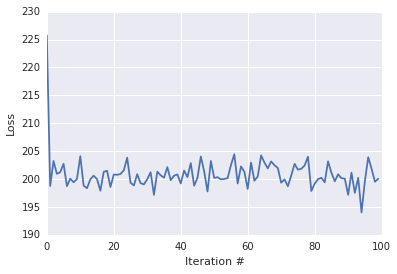

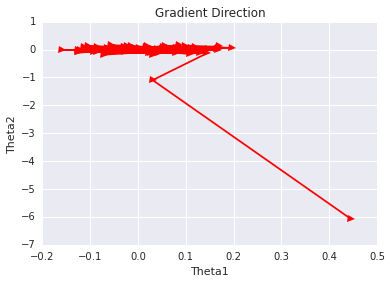

In [65]:
from pyspark.context import SparkContext
    
# Define parallel gradient descent algorithm
def parallel_gradient_descent(x_set, y_set, theta, learning_rate, n_epochs, m_impr, n_partitions = 4, sample_size=0.75):
    best_loss_index = 0
    
    # Broadcast parameters
    broadcastTheta = sc.broadcast(theta)
    broadcastParams = sc.broadcast([learning_rate])
    
    # Distribute data 
    data = np.array(list(zip(x_set, y_set)))
    distData = sc.parallelize(data, n_partitions)

    # Define gradient map function
    def gradient_map(iterator):
        # Load initial theta values
        th1 = broadcastTheta.value[0]
        th2 = broadcastTheta.value[1]
        
        # Load other parameters
        learning_rate = broadcastParams.value[0]
        
        # Calculate the contribute to gradient for each sample value
        loss = 0
        count = 0
        g1,g2 = 0,0
        for x, y in iterator:
            grad1 = th1 + (x * th2) - y
            grad2 = grad1 * x
            g1 += grad1
            g2 += grad2
        
            loss += ((th1 + th2*x - y)**2)*0.5
        
            th1 = th1 - learning_rate * grad1 
            th2 = th2 - learning_rate * grad2 
           
            count += 1
        yield ([[th1, th2], loss/count, [g1/count, g2/count], 1])    
        
    # Define gradient reducer function
    def gradient_reduce(data1, data2):
        th1 = data1[0][0] + data2[0][0]
        th2 = data1[0][1] + data2[0][1]
        loss = data1[1] + data2[1]
        grad1 = data1[2][0] + data2[2][0]
        grad2 = data1[2][1] + data2[2][1]
        count = data1[3] + data2[3]
        return ([th1, th2], loss, [grad1, grad2], count)
            
    loss_history = []
    theta_history = []
    grad_history = []
    for n in range(n_epochs):
        # Start a map-reduce tasks for each worker
        theta, loss, grad, count = (distData.sample(False, sample_size, 42 + n)
            .mapPartitions(gradient_map)
            .reduce(gradient_reduce)
        )
        
        theta[0] /= count
        theta[1] /= count
        broadcastTheta = sc.broadcast(theta)
        
        loss_history.append(loss / count)
        theta_history.append([theta[0], theta[1]])
        grad_history.append([grad[0] / count, grad[1] / count])
        
        # Verify that we are really improving
        if loss_history[best_loss_index] > loss_history[-1]:
            if abs(loss_history[-1] - loss_history[best_loss_index]) < m_impr:
                break
            best_loss_index = n
        
    return np.array(theta_history), np.array(loss_history), np.array(grad_history), n+1

# Start parallel gradient descent
theta, loss_history, grad_history, n_iterations = parallel_gradient_descent(x, y, np.array([0.7, 1.2]), 0.001, 100, 0.01)

# Output obtained results
print("Result obtained after", n_iterations, "iterations:")
print("\t- Loss:\t", loss_history[-1])
print("with final parameters:")
print("\t- Theta1:\t", theta[-1,0])
print("\t- Theta2:\t", theta[-1,1])

# Output scikit-learn results
print("Result obtained with scikit-learn:")
print("\t- Theta1:\t", intercept)
print("\t- Theta2:\t", slope)

# Plot loss/iteration#
plt.xlabel('Iteration #')
plt.ylabel('Loss')
plt.plot(range(0, n_iterations), loss_history)
plt.show()

# Plot gradient direction
plt.title('Gradient Direction')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.plot(grad_history[:,0], grad_history[:,1], 'r->')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 9.</strong> Inspecting your input data, and its partitioning.
<br>

Answer the following questions:
<ul>
    <li>What is the best way to partition your data, given your cluster configuration? How many partitions did you chose</li>
    <li>Given the number of partitions from the first point, how many RDD blocks is your data broken into?</li>
    <li>What would be different if you were to concieve the same algorithm digesting input data stored as a CSV file on HDFS? Argue about how to "ship" data to worker machines, partitions, blocks, etc...</li>
</ul>
</div>


**```[HINT]```** The questions above are best answered by looking at the Spark Master Web UI.

 * Since we have four workers, we have chosen to create four different partitions so that each worker has its own data stored locally. This also helps us to better exploit the data locality principle.
 * The RDD was split in as many blocks as the partitions were, which, in our case, was equals to 4.
 * The main difference would be that the dataset should not be serialized and sent to the worker machines but the worker nodes will just receive information about the CSV file. The worker nodes will then be in charge of loading a piece of this file from the distributed file system as it better suits their data locality principle needs. Of course, in this case the usage of the `parallelize` function would be useless since we would not need to parallelize data that are in driver's main memory.

<div class="alert alert-block alert-info">
<strong>Question 10.</strong> Finding bottlenecks.

<ul>
    <li>What is the bottleneck in the current implementation of your algorithm?</li>
    <li>Can you nail down exactly which method is causing this bottleneck?</li>
    <li>Can you suggest ways to mitigate or eliminate the bottleneck?</li>
</ul>
</div>

 * The bottleneck in our implementation is the driver collecting all the data. This happens because, after the reduce operation, the data computed by the workers is sent back to the driver machie. However, since our problem does not involve a "big data"-sized dataset, we can not really appreciate this bottleneck.
 * The method causing the mentioned bottleneck is the `reduce` because it is the one responsible for making Spark to send the results to the driver.
 * A possible solution to mitigate the effects of the described bottleneck could be to reduce the amount of data the workers are sending to the driver machine. This could be done by using the `treeReduce` function instead of the `reduce`. In fact, by using the `treeReduce` function, Spark starts a partial aggregation of the results data on a small set of executors before sending them to the driver. Obviously this drastically reduces the load the driver has to deal with, also reducing the possibilities of bottlenecks. 

<div class="alert alert-block alert-info">
<strong>Question 11.</strong> Comparison of serial vs. distributed algorithms.
</div>

Given all the implementation effort you did so far, this question is about an experimental study on scalability. Given input data sizes in the range $[10^2, 10^3, 10^4, 10^5]$, collect the run-time and the loss rate at convergence for all variants of the serial algorithms and for the distributed one. Produce a plot with 2 y-axis, one for the run-time, one for the loss rate, and one x-axis with the input data size.

Discuss your results.


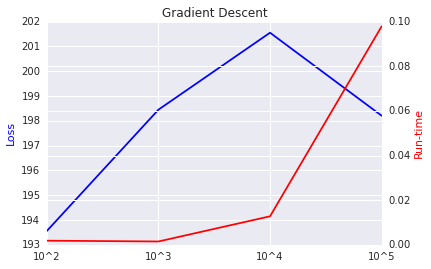

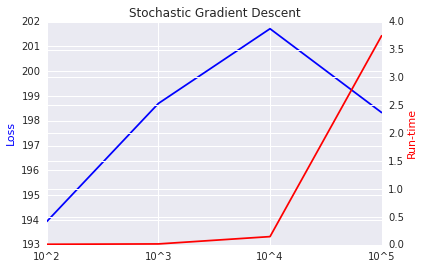

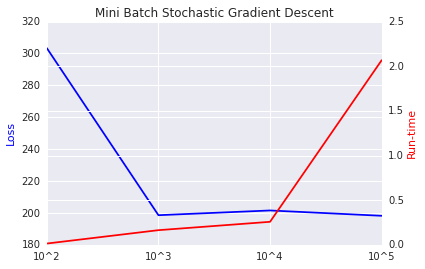

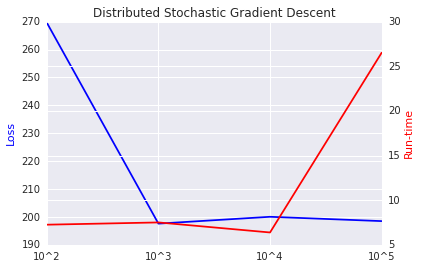

In [66]:
import time

def performance_plot(alg, label, params):
    losses = []
    times = []
    
    for n in range(2, 6):
        # Generate the input data
        x, y = make_regression(n_samples = 10**n, 
                            n_features=1, 
                            n_informative=1, 
                            noise=20,
                            random_state=2017)
        x = x.flatten()
    
        # Compute algorithm results
        start_t = time.time()
        _, loss, _, _ = alg(x, y, params[0], params[1], params[2], params[3])
        end_t = time.time()

        # Compute execution time
        dt = end_t - start_t

        # Store obtained results
        losses.append(loss[-1])
        times.append(dt)
        
    # Plot loss
    x_values = range(0, 4)
    
    fig, ax1 = plt.subplots()
    
    plt.title(label)
    ax1.set_ylabel('Loss', color='b')
    ax1.plot(x_values, losses, 'b')

    # Plot run-time
    ax2 = ax1.twinx()
    ax2.set_ylabel('Run-time', color='r')
    ax2.plot(x_values, times, 'r-')

    plt.xticks([0, 1, 2, 3], ["10^2", "10^3", "10^4", "10^5"])    
    plt.show()

# Plot for each algorithm
algorithms = [ (gradient_descent, 'Gradient Descent', [np.array([0.7, 1.2]), 0.1, 100, 0.01 ]), 
              (stochastic_gradient_descent, 'Stochastic Gradient Descent', [ np.array([0.7, 1.2]), 0.001, 100, 0.01 ]), 
              (mb_gradient_descent, 'Mini Batch Stochastic Gradient Descent', [ np.array([0.7, 1.2]), 0.005, 100, 0.01 ]),
              (parallel_gradient_descent, 'Distributed Stochastic Gradient Descent', [ np.array([0.7, 1.2]), 0.001, 100, 0.01 ]) ]
for alg, label, params in algorithms:
    performance_plot(alg, label, params)

Before commenting, it must be stated that it was decided to generate four different plots for each algorithm, instead of one collecting the results from all of them only for the sake of clarity. 

The algorithms were tested using the same parameters on all the input dataset because we want to see how the same algorithm can perform in different circumstances. In particular, all of them has initial theta values equal to 0.7 and 1.2 respectively, the same number of maximum iterations, equals to 100, and the same marginal improvement vale, equals to 0.01. The other parameters are:
 - Gradient Descent: learning rate equals to 0.1
 - Stochastic Gradient Descent: learning rate equals to 0.001
 - Mini-batch Stochastic Gradient Descent: learning rate equals to 0.005
 - Distributed Gradient Descent: learning rate equals to 0.001
 
Regarding the run-time results, we can see that it grows exponentially with the size of the dataset. Comparing the different algorithms we can see that the fastest one is the Gradient Descent. This is supposed to be an unusual result if compared with those of the distributed algorithm but, since we are operating on relatively small datasets, even the overhead required for distributing the data has a major impact on the total computational time. The slowest algorithm is the Stochastic Gradient Descent because, once it reaches a good solution, it keeps oscillating around it without stopping. On the other side, the Mini Batch Stochastic Gradient Descent run-time performances are a compromise between Gradient Descent and Stochastic Gradient Descent. In fact it takes less time than the Stochastic Gradient Descent, but more time than the normal Gradient Descent. 

The only unusual result we can see when examining the run-time performances is in the distributed algorithm. By looking at the plot, indeed, we can see that the run-time decreases when analyzing the $10^4$ sized dataset with respect to the smaller ones. This anomaly is due to the fact that, with the $10^4$ we start taking advantage of the distribution of the computation while, for smaller instances, the network overhead has a major influence on the computational time.

Regarding the obtained loss values we can observe that they are very similar to each other. The only difference is that, as we explained before, the different algorithms reach those values in different times, with time intented here as the number of iterations. Moreover we can also observe as the Mini-batch algorithm is the one with the worst performances on the smaller datasets.

Both the Mini-batch and the Distributed algorithms have bad performances on loss with small instances. Those two algorithms were expected to have very similar results through, since the Distributed Gradient Descent is, from a high point of view, a sort of Mini-batch algorithm, were batches computation is distributed among our workers which internally implement a Stochastic Gradient Descent algorithm.

The distributed algorithm apparently seems to perform better than the others. Anyway this behaviour is erroneous although expected since we are sampling the original dataset. In fact a sample can never be perfectly representative of a population because, when sampling, we always have to assume we are doing a sampling error.

An additional note should be made about scalability. The chosen number of partitions in the distributed implementation was 4. This because we have a realatively small cluster and we are analyzing small datasets. Anyway, if we had to work with a larger cluster or with a larger dataset, then the distribution of the computation could be increased easily, since the number of partitions is a parameter for the distributed algorithm function. Moreover we could also tune the sample size as we need while, by default, it is set to sample the 75% of the entire population.